<h1 align="center">  Yoga Pose Classification </h1>

<p style="text-align:center"><img src="https://i.ibb.co/dkZr34n/yoga.jpg" alt="yoga" width="500" height="600"></p>


Yoga is a spiritual and physical practice that originated in ancient India. It has gained worldwide popularity in recent years due to its numerous health benefits, such as increased flexibility, strength, and relaxation. There are various styles of yoga, including Hatha, Vinyasa, and Ashtanga, each with its own unique set of poses or asanas.

Yoga pose classification is the process of automatically recognizing and categorizing different yoga poses from images or videos using deep learning techniques. This can be useful for yoga practitioners, instructors, and researchers who want to track progress, analyze movements, and identify common errors in pose alignment.

## Import Libraries

In [1]:
import os 
import random
from tqdm import tqdm
import pickle

import tensorflow as tf
import cv2
import mediapipe as mp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

## Create Spatial Graph

<img src="https://camo.githubusercontent.com/7fbec98ddbc1dc4186852d1c29487efd7b1eb820c8b6ef34e113fcde40746be2/68747470733a2f2f6d65646961706970652e6465762f696d616765732f6d6f62696c652f706f73655f747261636b696e675f66756c6c5f626f64795f6c616e646d61726b732e706e67" />

In [2]:
# 0. nose 1. left_eye_inner 2. left_eye 3. left_eye_outer 4. right_eye_inner 5. right_eye 6. right_eye_outer 7. left_ear 8. right_ear 9. mouth_left 10. mouth_right 11. left_shoulder 12. right_shoulder 13. left_elbow 14. right_elbow 15. left_wrist 16. right_wrist 
# 17. left_pinky 18. right_pinky 19. left_index 20. right_index 21. left_thumb 22. right_thumb 23. left_hip 24. right_hip 25. left_knee 26. right_knee 27. left_ankle 28. right_ankle 29. left_heel 30. right_heel 31. left_foot_index 32. right_foot_index 

joints_edges = pd.DataFrame(
    {"source": 
     [
      "nose", #0
      "nose", #0
      "left_eye_inner", #1
      "left_eye", #2
      "right_eye_inner", #4
      "right_eye", #5
      "left_eye_outer", #3
      "right_eye_outer", #6
      "mouth_right", #10
      "mouth_right", #10 
      "mouth_left", #9
      "right_shoulder", #12
      "left_shoulder", #11
      "right_elbow", #14
      "left_elbow", #13
      "right_wrist", #16
      "left_wrist", #15
      "right_wrist", #16
      "left_wrist", #15
      "right_wrist", #16 
      "left_wrist", #15 
      "right_index", #20
      "left_index", #19
      "right_shoulder", #12
      "right_shoulder", #12
      "left_shoulder", #11
      "right_hip", #24
      "left_hip", #23
      "right_knee", #26
      "left_knee", #25
      "right_ankle", #28
      "left_ankle", #27
      "right_ankle", #28
      "left_ankle", #27,
      "right_foot_index", #32
      "left_foot_index", #31
      "right_hip", #24
      ], 
     "target": 
     [
      "left_eye_inner", #1
      "right_eye_inner", #4
      "left_eye", #2
      "left_eye_outer", #3
      "right_eye", #5
      "right_eye_outer", #6
      "left_ear", #7
      "right_ear", #8
      "mouth_left", #9
      "right_shoulder",#12
      "left_shoulder", #11
      "right_elbow", #14
      "left_elbow", #13
      "right_wrist",#16 
      "left_wrist", #15 
      "right_pinky", #18
      "left_pinky", #17
      "right_thumb", #22
      "left_thumb", #21
      "right_index", #20
      "left_index", #19
      "right_pinky", #18
      "left_pinky", #17
      "left_shoulder", #11
      "right_hip", #24
      "left_hip", #23
      "right_knee", #26
      "left_knee", #25
      "right_ankle", #28
      "left_ankle", #27
      "right_foot_index", #32
      "left_foot_index", #31
      "right_heel", #30
      "left_heel", #29
      "right_heel", #30
      "left_heel", #29
      "left_hip", #23

    ]}
)
joints_edges

,source,target
0,nose,left_eye_inner
1,nose,right_eye_inner
2,left_eye_inner,left_eye
3,left_eye,left_eye_outer
4,right_eye_inner,right_eye
5,right_eye,right_eye_outer
6,left_eye_outer,left_ear
7,right_eye_outer,right_ear
8,mouth_right,mouth_left
9,mouth_right,right_shoulder


In [3]:
skeleton = StellarGraph(edges=joints_edges)

In [4]:
print(skeleton.info())

StellarGraph: Undirected multigraph
 Nodes: 33, Edges: 37

 Node types:
  default: [33]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [37]
        Weights: all 1 (default)
        Features: none


## Train Test Split

<img src="https://b1739487.smushcdn.com/1739487/wp-content/uploads/2021/04/train-and-test-1-min-1.png?lossy=0&strip=1&webp=1" width="200" height="200" >

In [5]:
image_dirs = os.listdir("./Dataset/Extracted_Images/")
image_dir_labels = [x.split("_")[1] for x in os.listdir("./Dataset/Extracted_Images/")]

In [8]:
train_dir, test_dir, train_dir_labels, test_dir_labels = train_test_split(image_dirs, image_dir_labels, test_size=0.15, stratify=image_dir_labels, random_state=23)

In [9]:
len(train_dir), len(test_dir), len(train_dir_labels), len(test_dir_labels)

(74, 14, 74, 14)

## Create Features

In [10]:
random.seed(5)

In [11]:
# set up MediaPipe pose estimation model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# function to extract pose landmarks from an image
def extract_pose_landmarks(image_file):
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        image = cv2.imread(image_file)
        results = pose.process(image)
        if results.pose_landmarks is not None:
            landmarks = np.array([[lmk.x, lmk.y, lmk.z] for lmk in results.pose_landmarks.landmark]).flatten()
        else:
            landmarks = np.zeros(33*3)
        return landmarks

In [12]:
train_labels = []
train_image_features = []
train_image_names = []

for idx, folder in tqdm(enumerate(train_dir)):
    train_img_list = os.listdir(f"./Dataset/Extracted_Images/{folder}")
    random.shuffle(train_img_list)
    for img in train_img_list[:30]:
        try:
            train_image_features.append(extract_pose_landmarks(f"./Dataset/Extracted_Images/{folder}/{img}"))
            train_image_names.append(img)
            train_labels.append(train_dir_labels[idx])
        except:
            pass

74it [08:50,  7.17s/it]


In [22]:
test_labels = []
test_image_features = []
test_image_names = []

for idx, folder in tqdm(enumerate(test_dir)):
    test_img_list = os.listdir(f"./Dataset/Extracted_Images/{folder}")
    random.shuffle(test_img_list)
    for img in test_img_list[:30]:
        try:
            test_image_features.append(extract_pose_landmarks(f"./Dataset/Extracted_Images/{folder}/{img}"))
            test_image_names.append(img)
            test_labels.append(train_dir_labels[idx])
        except:
            pass

14it [01:08,  4.89s/it]


In [134]:
features = ['nose', 'left_eye_inner', 'left_eye', 'left_eye_outer', 'right_eye_inner', 'right_eye', 'right_eye_outer', 'left_ear', 'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index', 'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle', 'left_heel', 'right_heel', 'left_foot_index', 'right_foot_index']

In [135]:
extended_features = []
for kp in features:
    extended_features.append(kp + '_x')
    extended_features.append(kp + '_y')
    extended_features.append(kp + '_z')

In [136]:
train_feature_df = pd.DataFrame(train_image_features, columns=extended_features)
train_labels_df = pd.DataFrame(train_labels, columns=["Class"])
train_image_names_df = pd.DataFrame(train_image_names, columns=["Id"])

In [152]:
test_feature_df = pd.DataFrame(test_image_features, columns=extended_features)
test_labels_df = pd.DataFrame(test_labels, columns=["Class"])
test_image_names_df = pd.DataFrame(test_image_names, columns=["Id"])

In [137]:
train_image_dict = train_image_names_df.to_dict()["Id"]

In [153]:
test_image_dict = test_image_names_df.to_dict()["Id"]

In [138]:
train_feature_df = pd.concat([pd.DataFrame(list(train_image_dict.keys()), columns=["Id"]), train_labels_df, train_feature_df],axis=1)

In [154]:
test_feature_df = pd.concat([pd.DataFrame(list(test_image_dict.keys()), columns=["Id"]), test_labels_df, test_feature_df],axis=1)

In [139]:
train_feature_df.head()

,Id,Class,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0,Shavasana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,Shavasana,0.564131,0.763295,-0.011893,0.570441,0.770236,-0.022171,0.570657,0.772847,...,-0.090803,0.329233,0.804130,0.036659,0.296983,0.793503,-0.119813,0.317110,0.759629,0.014587
2,2,Shavasana,0.567497,0.786370,0.008722,0.569996,0.789752,0.006951,0.570339,0.792742,...,-0.098587,0.417869,0.805594,-0.022436,0.386089,0.807933,-0.139511,0.400073,0.784528,-0.051421
3,3,Shavasana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,Shavasana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [155]:
test_feature_df.head()

,Id,Class,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0,Shavasana,0.500138,0.237671,-0.262711,0.503819,0.224897,-0.245006,0.506354,0.224591,...,0.243281,0.489272,0.750340,0.244108,0.509598,0.786093,0.132512,0.485573,0.786853,0.134133
1,1,Shavasana,0.500284,0.231220,-0.304633,0.503356,0.221600,-0.287387,0.506048,0.221993,...,0.217322,0.487271,0.743398,0.214947,0.524875,0.783686,0.107164,0.482087,0.779681,0.105247
2,2,Shavasana,0.500571,0.232580,-0.224170,0.504465,0.219261,-0.205361,0.506895,0.219381,...,0.214372,0.485201,0.747282,0.208203,0.509602,0.783474,0.104461,0.484044,0.781356,0.097478
3,3,Shavasana,0.508174,0.233696,-0.332174,0.511530,0.221317,-0.314308,0.513963,0.221342,...,0.223193,0.484646,0.750813,0.216459,0.510031,0.787682,0.113141,0.483954,0.785798,0.103951
4,4,Shavasana,0.499476,0.228575,-0.258585,0.503362,0.215900,-0.240610,0.505736,0.216043,...,0.243748,0.487642,0.747996,0.236478,0.509521,0.785864,0.134293,0.484907,0.785124,0.127191


In [140]:
# Drop Null
train_feature_df = train_feature_df.drop(index=train_feature_df[train_feature_df["nose_x"] == 0].index)

In [156]:
# Drop Null
test_feature_df = test_feature_df.drop(index=test_feature_df[test_feature_df["nose_x"] == 0].index)

In [141]:
train_feature_df.head()

,Id,Class,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
1,1,Shavasana,0.564131,0.763295,-0.011893,0.570441,0.770236,-0.022171,0.570657,0.772847,...,-0.090803,0.329233,0.804130,0.036659,0.296983,0.793503,-0.119813,0.317110,0.759629,0.014587
2,2,Shavasana,0.567497,0.786370,0.008722,0.569996,0.789752,0.006951,0.570339,0.792742,...,-0.098587,0.417869,0.805594,-0.022436,0.386089,0.807933,-0.139511,0.400073,0.784528,-0.051421
5,5,Shavasana,0.572159,0.810181,-0.045015,0.574592,0.812157,-0.053370,0.574578,0.814916,...,-0.017329,0.454167,0.787131,0.054810,0.421906,0.791412,-0.041944,0.431491,0.766583,0.034100
6,6,Shavasana,0.564999,0.760537,0.049920,0.570525,0.768322,0.039744,0.570499,0.770988,...,-0.149871,0.290564,0.798518,0.001519,0.263788,0.776098,-0.195131,0.282191,0.740575,-0.030798
22,22,Shavasana,0.563284,0.766907,-0.098344,0.570562,0.773575,-0.108286,0.570950,0.777153,...,-0.084642,0.329053,0.836635,0.050049,0.304917,0.830246,-0.130011,0.320994,0.791969,0.015671


In [157]:
test_feature_df.head()

,Id,Class,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0,Shavasana,0.500138,0.237671,-0.262711,0.503819,0.224897,-0.245006,0.506354,0.224591,...,0.243281,0.489272,0.750340,0.244108,0.509598,0.786093,0.132512,0.485573,0.786853,0.134133
1,1,Shavasana,0.500284,0.231220,-0.304633,0.503356,0.221600,-0.287387,0.506048,0.221993,...,0.217322,0.487271,0.743398,0.214947,0.524875,0.783686,0.107164,0.482087,0.779681,0.105247
2,2,Shavasana,0.500571,0.232580,-0.224170,0.504465,0.219261,-0.205361,0.506895,0.219381,...,0.214372,0.485201,0.747282,0.208203,0.509602,0.783474,0.104461,0.484044,0.781356,0.097478
3,3,Shavasana,0.508174,0.233696,-0.332174,0.511530,0.221317,-0.314308,0.513963,0.221342,...,0.223193,0.484646,0.750813,0.216459,0.510031,0.787682,0.113141,0.483954,0.785798,0.103951
4,4,Shavasana,0.499476,0.228575,-0.258585,0.503362,0.215900,-0.240610,0.505736,0.216043,...,0.243748,0.487642,0.747996,0.236478,0.509521,0.785864,0.134293,0.484907,0.785124,0.127191


In [142]:
dataFrames = []
graphLabels = []
for index, row in train_feature_df.iterrows():
    graphLabels.append(row['Class'])
    processedDf = pd.DataFrame(
    {
        "x": [
              row['nose_x'],
              row['left_eye_inner_x'],
              row['left_eye_x'],
              row['left_eye_outer_x'],
              row['right_eye_inner_x'],
              row['right_eye_x'],
              row['right_eye_outer_x'],
              row['left_ear_x'],
              row['right_ear_x'],
              row['mouth_left_x'],
              row['mouth_right_x'],
              row['left_shoulder_x'],
              row['right_shoulder_x'],
              row['left_elbow_x'],
              row['right_elbow_x'],
              row['left_wrist_x'],
              row['right_wrist_x'],
              row['left_pinky_x'],
              row['right_pinky_x'],
              row['left_index_x'],
              row['right_index_x'],
              row['left_thumb_x'],
              row['right_thumb_x'],
              row['left_hip_x'],
              row['right_hip_x'],
              row['left_knee_x'],
              row['right_knee_x'],
              row['left_ankle_x'],
              row['right_ankle_x'],
              row['left_heel_x'],
              row['right_heel_x'],
              row['left_foot_index_x'],
              row['right_foot_index_x'],
        ], 
        "y": [
              row['nose_y'],
              row['left_eye_inner_y'],
              row['left_eye_y'],
              row['left_eye_outer_y'],
              row['right_eye_inner_y'],
              row['right_eye_y'],
              row['right_eye_outer_y'],
              row['left_ear_y'],
              row['right_ear_y'],
              row['mouth_left_y'],
              row['mouth_right_y'],
              row['left_shoulder_y'],
              row['right_shoulder_y'],
              row['left_elbow_y'],
              row['right_elbow_y'],
              row['left_wrist_y'],
              row['right_wrist_y'],
              row['left_pinky_y'],
              row['right_pinky_y'],
              row['left_index_y'],
              row['right_index_y'],
              row['left_thumb_y'],
              row['right_thumb_y'],
              row['left_hip_y'],
              row['right_hip_y'],
              row['left_knee_y'],
              row['right_knee_y'],
              row['left_ankle_y'],
              row['right_ankle_y'],
              row['left_heel_y'],
              row['right_heel_y'],
              row['left_foot_index_y'],
              row['right_foot_index_y'],
        ], 
        "z": [
              row['nose_z'],
              row['left_eye_inner_z'],
              row['left_eye_z'],
              row['left_eye_outer_z'],
              row['right_eye_inner_z'],
              row['right_eye_z'],
              row['right_eye_outer_z'],
              row['left_ear_z'],
              row['right_ear_z'],
              row['mouth_left_z'],
              row['mouth_right_z'],
              row['left_shoulder_z'],
              row['right_shoulder_z'],
              row['left_elbow_z'],
              row['right_elbow_z'],
              row['left_wrist_z'],
              row['right_wrist_z'],
              row['left_pinky_z'],
              row['right_pinky_z'],
              row['left_index_z'],
              row['right_index_z'],
              row['left_thumb_z'],
              row['right_thumb_z'],
              row['left_hip_z'],
              row['right_hip_z'],
              row['left_knee_z'],
              row['right_knee_z'],
              row['left_ankle_z'],
              row['right_ankle_z'],
              row['left_heel_z'],
              row['right_heel_z'],
              row['left_foot_index_z'],
              row['right_foot_index_z'],
        ],
    },
        index=[
               "nose",
               "left_eye_inner", 
               "left_eye", 
               "left_eye_outer",
               "right_eye_inner", 
               "right_eye", 
               "right_eye_outer",
               "left_ear",
               "right_ear",
               "mouth_left",
               "mouth_right",
               "left_shoulder",
               "right_shoulder",
               "left_elbow",
               "right_elbow",
               "left_wrist",
               "right_wrist",
               "left_pinky",
               "right_pinky",
               "left_index",
               "right_index",
               "left_thumb",
               "right_thumb",
               "left_hip",
               "right_hip",
               "left_knee",
               "right_knee",
               "left_ankle",
               "right_ankle",
               "left_heel",
               "right_heel",
               "left_foot_index",
               "right_foot_index"
              ]
)
    dataFrames.append(processedDf)

In [143]:
dataFrames[0]
graphLabels[0]

'Shavasana'

In [144]:
square_node_features = StellarGraph(dataFrames[0], joints_edges)
print(square_node_features.info())

StellarGraph: Undirected multigraph
 Nodes: 33, Edges: 37

 Node types:
  default: [33]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [37]
        Weights: all 1 (default)
        Features: none


In [158]:
test_dataFrames = []
test_graphLabels = []
for index, row in test_feature_df.iterrows():
    graphLabels.append(row['Class'])
    processedDf = pd.DataFrame(
    {
        "x": [
              row['nose_x'],
              row['left_eye_inner_x'],
              row['left_eye_x'],
              row['left_eye_outer_x'],
              row['right_eye_inner_x'],
              row['right_eye_x'],
              row['right_eye_outer_x'],
              row['left_ear_x'],
              row['right_ear_x'],
              row['mouth_left_x'],
              row['mouth_right_x'],
              row['left_shoulder_x'],
              row['right_shoulder_x'],
              row['left_elbow_x'],
              row['right_elbow_x'],
              row['left_wrist_x'],
              row['right_wrist_x'],
              row['left_pinky_x'],
              row['right_pinky_x'],
              row['left_index_x'],
              row['right_index_x'],
              row['left_thumb_x'],
              row['right_thumb_x'],
              row['left_hip_x'],
              row['right_hip_x'],
              row['left_knee_x'],
              row['right_knee_x'],
              row['left_ankle_x'],
              row['right_ankle_x'],
              row['left_heel_x'],
              row['right_heel_x'],
              row['left_foot_index_x'],
              row['right_foot_index_x'],
        ], 
        "y": [
              row['nose_y'],
              row['left_eye_inner_y'],
              row['left_eye_y'],
              row['left_eye_outer_y'],
              row['right_eye_inner_y'],
              row['right_eye_y'],
              row['right_eye_outer_y'],
              row['left_ear_y'],
              row['right_ear_y'],
              row['mouth_left_y'],
              row['mouth_right_y'],
              row['left_shoulder_y'],
              row['right_shoulder_y'],
              row['left_elbow_y'],
              row['right_elbow_y'],
              row['left_wrist_y'],
              row['right_wrist_y'],
              row['left_pinky_y'],
              row['right_pinky_y'],
              row['left_index_y'],
              row['right_index_y'],
              row['left_thumb_y'],
              row['right_thumb_y'],
              row['left_hip_y'],
              row['right_hip_y'],
              row['left_knee_y'],
              row['right_knee_y'],
              row['left_ankle_y'],
              row['right_ankle_y'],
              row['left_heel_y'],
              row['right_heel_y'],
              row['left_foot_index_y'],
              row['right_foot_index_y'],
        ], 
        "z": [
              row['nose_z'],
              row['left_eye_inner_z'],
              row['left_eye_z'],
              row['left_eye_outer_z'],
              row['right_eye_inner_z'],
              row['right_eye_z'],
              row['right_eye_outer_z'],
              row['left_ear_z'],
              row['right_ear_z'],
              row['mouth_left_z'],
              row['mouth_right_z'],
              row['left_shoulder_z'],
              row['right_shoulder_z'],
              row['left_elbow_z'],
              row['right_elbow_z'],
              row['left_wrist_z'],
              row['right_wrist_z'],
              row['left_pinky_z'],
              row['right_pinky_z'],
              row['left_index_z'],
              row['right_index_z'],
              row['left_thumb_z'],
              row['right_thumb_z'],
              row['left_hip_z'],
              row['right_hip_z'],
              row['left_knee_z'],
              row['right_knee_z'],
              row['left_ankle_z'],
              row['right_ankle_z'],
              row['left_heel_z'],
              row['right_heel_z'],
              row['left_foot_index_z'],
              row['right_foot_index_z'],
        ],
    },
        index=[
               "nose",
               "left_eye_inner", 
               "left_eye", 
               "left_eye_outer",
               "right_eye_inner", 
               "right_eye", 
               "right_eye_outer",
               "left_ear",
               "right_ear",
               "mouth_left",
               "mouth_right",
               "left_shoulder",
               "right_shoulder",
               "left_elbow",
               "right_elbow",
               "left_wrist",
               "right_wrist",
               "left_pinky",
               "right_pinky",
               "left_index",
               "right_index",
               "left_thumb",
               "right_thumb",
               "left_hip",
               "right_hip",
               "left_knee",
               "right_knee",
               "left_ankle",
               "right_ankle",
               "left_heel",
               "right_heel",
               "left_foot_index",
               "right_foot_index"
              ]
)
    test_dataFrames.append(processedDf)




In [164]:
test_dataFrames[0]

,x,y,z
nose,0.500138,0.237671,-0.262711
left_eye_inner,0.503819,0.224897,-0.245006
left_eye,0.506354,0.224591,-0.244966
left_eye_outer,0.508531,0.224287,-0.245001
right_eye_inner,0.495427,0.226010,-0.247755
right_eye,0.492133,0.226578,-0.247788
right_eye_outer,0.489059,0.227017,-0.247787
left_ear,0.511884,0.227853,-0.146117
right_ear,0.484228,0.231412,-0.156731
mouth_left,0.505575,0.250821,-0.224799


In [165]:
test_square_node_features = StellarGraph(test_dataFrames[0], joints_edges)
print(test_square_node_features.info())

StellarGraph: Undirected multigraph
 Nodes: 33, Edges: 37

 Node types:
  default: [33]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [37]
        Weights: all 1 (default)
        Features: none


## Generate Stellar Graph

In [104]:
graphs = []
for item in dataFrames:
  graph = StellarGraph(item, joints_edges)
  graphs.append(graph)

In [105]:
print(graphs[100].info())

StellarGraph: Undirected multigraph
 Nodes: 33, Edges: 37

 Node types:
  default: [33]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [37]
        Weights: all 1 (default)
        Features: none


In [106]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1788.0,1788.0
mean,33.0,37.0
std,0.0,0.0
min,33.0,37.0
25%,33.0,37.0
50%,33.0,37.0
75%,33.0,37.0
max,33.0,37.0


In [107]:
graph_labels = pd.get_dummies(graphLabels, drop_first=True)

In [108]:
graph_labels

,Padmasana,Shavasana,Tadasana,Trikonasana,Vrikshasana
0,False,True,False,False,False
1,False,True,False,False,False
2,False,True,False,False,False
3,False,True,False,False,False
4,False,True,False,False,False
...,...,...,...,...,...
1783,False,False,False,True,False
1784,False,False,False,True,False
1785,False,False,False,True,False
1786,False,False,False,True,False


In [109]:
graph_labels.value_counts().to_frame()

count
Padmasana Shavasana Tadasana Trikonasana Vrikshasana       
False     False     True     False       False          384
                    False    False       True           360
True      False     False    False       False          358
False     False     False    True        False          327
                             False       False          221
          True      False    False       False          138

## Create the Model

In [110]:
generator = PaddedGraphGenerator(graphs=graphs)

In [145]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=6, activation="softmax")(predictions)

    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss="categorical_crossentropy", metrics=["acc"])

    return model

In [167]:
model = create_graph_classification_model(generator)

In [149]:
def get_generators(graph_labels, test_graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=test_graph_labels.values, batch_size=batch_size
    )

    return train_gen, test_gen

In [166]:
train_generator, test_generator = get_generators(
        graph_labels, test_graph_labels, batch_size=16
)

## Define Callbacks

In [168]:
ES = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=False)
MC = tf.keras.callbacks.ModelCheckpoint("./models/sgcnn_model.h5", monitor="val_loss", save_weights_only=False, save_best_only=True)

callbacks=[ES,MC]

## Train Model

In [25]:
history = model.fit( 
    train_generator, 
    validation_data= (test_generator),
    epochs=1000,
    callbacks=callbacks, 
)

Epoch 1/1000
139/139 [==============================] - 23s 156ms/step - loss: 2.7729 - accuracy: 0.7967 - precision: 0.8332 - recall: 0.7424 - val_loss: 376.6708 - val_accuracy: 0.3810 - val_precision: 0.3810 - val_recall: 0.3810
Epoch 2/1000
139/139 [==============================] - 20s 147ms/step - loss: 0.3804 - accuracy: 0.9381 - precision: 0.9457 - recall: 0.9291 - val_loss: 0.2112 - val_accuracy: 0.9429 - val_precision: 0.9424 - val_recall: 0.9357
Epoch 3/1000
139/139 [==============================] - 19s 140ms/step - loss: 0.3146 - accuracy: 0.9589 - precision: 0.9669 - recall: 0.9503 - val_loss: 108.6230 - val_accuracy: 0.5357 - val_precision: 0.5346 - val_recall: 0.5333
Epoch 4/1000
139/139 [==============================] - 19s 140ms/step - loss: 0.3666 - accuracy: 0.9449 - precision: 0.9510 - recall: 0.9390 - val_loss: 142.3862 - val_accuracy: 0.5524 - val_precision: 0.5526 - val_recall: 0.5500
Epoch 5/1000
139/139 [==============================] - 19s 140ms/step - loss:

## Load Best Model 

In [172]:
best_model = tf.keras.models.load_model("./models/sgcnn_model.h5")

## Model Evaluation

Evaluating the vision model involves assessing the effectiveness of a model in predicting the correct class labels for a set of images. To evaluate the performance of a vision model, we used various performance metrics like precision, recall, accuracy, F1 score, confusion matrix, and classification report. Here is an explanation of each metric:

1. **Precision**: Precision is the fraction of true positive predictions (TP) among the total positive predictions made by the model. It measures how well the model correctly identifies positive instances (in the context of a vision model, it is the correct classification of images). The formula for precision is:

    $$ Precision = \frac{TP}{TP + FP} $$

   where TP is the number of true positives, and FP is the number of false positives.

2. **Recall**: Recall is the fraction of true positive predictions (TP) among the total actual positive instances. It measures how well the model identifies all the positive instances. The formula for recall is:

    $$ Recall = \frac{TP}{TP + FN} $$

   where TP is the number of true positives, and FN is the number of false negatives.

3. **Accuracy**: Accuracy is the fraction of correct predictions (both true positives and true negatives) among the total number of predictions made by the model. The formula for accuracy is:

    $$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

   where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.


4. **F1 Score**: The F1 score is the harmonic mean of precision and recall. It is used when both precision and recall are equally important. The formula for the F1 score is:

    $$ F1 Score = 2 * \frac{Precision * Recall}{Precision + Recall} $$

5. **Confusion Matrix**: A confusion matrix is a table that is used to describe the performance of a classification model. It shows the true positive, true negative, false positive, and false negative predictions for each class label. The confusion matrix is represented as:

    ```
    [ [ TP, FP ],
      [ FN, TN ] ]
    ```

   where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.

6. **Classification Report**: A classification report is a summary of the performance metrics (precision, recall, F1 score, and support) for each class label. It includes the following information:

    - Precision, recall, and F1 score for each class label
    - Macro-average and weighted average for precision, recall, and F1 score across all class labels
    - Total support (the number of instances in each class label)

In [176]:
# Load Test Graph and Test Labels
with open("./Assets/test_graph", "rb") as f:
    test_graph = pickle.load(f)
    
with open("./Assets/test_labels", "rb") as f:
    test_labels = pickle.load(f)

In [177]:
pred_test = best_model.predict(test_graph)

14/14 [==============================] - 6s 55ms/step


In [178]:
pred_test = np.argmax(pred_test, axis=1)

In [179]:
y_true = np.argmax(test_labels, axis=1)
y_pred = pred_test

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average="macro") * 100
recall = recall_score(y_true, y_pred, average="macro") * 100
f1 = f1_score(y_true, y_pred, average="macro") * 100

# Print evaluation metrics
print("Test Accuracy: {:.2f}%".format(accuracy))
print("Test Precision: {:.2f}%".format(precision))
print("Test Recall: {:.2f}%".format(recall))
print("Test F1 score: {:.2f}%".format(f1))

Test Accuracy: 94.29%
Test Precision: 94.50%
Test Recall: 94.91%
Test F1 score: 94.49%


In [180]:
report = classification_report(y_true, y_pred)

print("Classification report:\n", report)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      0.97      0.98        60
           2       1.00      1.00      1.00        60
           3       0.77      0.93      0.84        60
           4       0.97      0.98      0.98        60
           5       0.94      0.81      0.87        90

    accuracy                           0.94       420
   macro avg       0.95      0.95      0.94       420
weighted avg       0.95      0.94      0.94       420



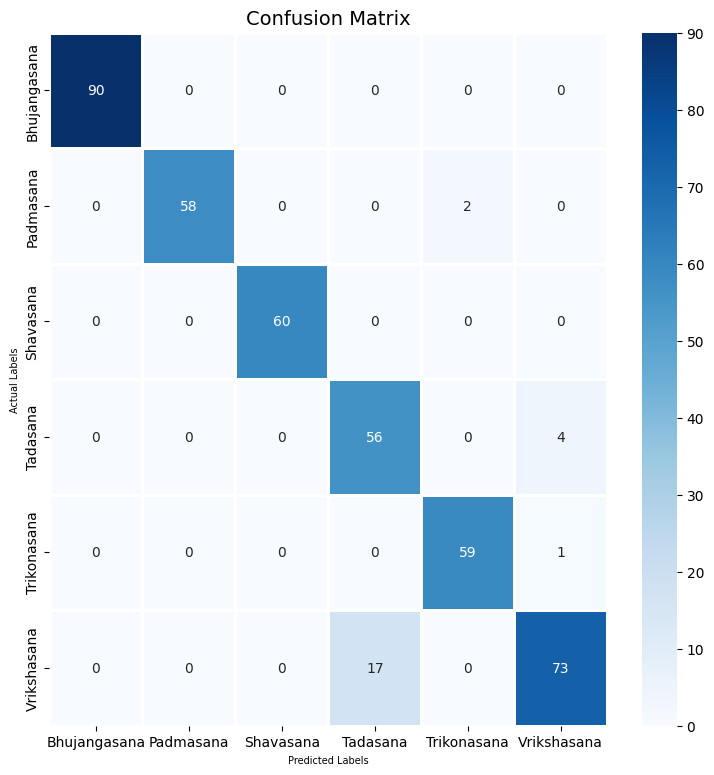

In [181]:
# Create confusion matrix and plot heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (9, 9))
cm = pd.DataFrame(cm , columns = ['Bhujangasana', 'Padmasana', 'Shavasana', 'Tadasana', 'Trikonasana', 'Vrikshasana'], index=['Bhujangasana', 'Padmasana', 'Shavasana', 'Tadasana', 'Trikonasana', 'Vrikshasana'])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=14)
plt.xlabel('Predicted Labels', size=7)
plt.ylabel('Actual Labels', size=7)
plt.show()